In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from scipy import stats
import os
import model_evaluation_utils as meu
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.preprocessing import get_feature_names
from collections import Counter

%matplotlib inline
import pickle
import warnings

In [2]:
cwd = os.getcwd()
cwd

'C:\\Users\\mstre\\Dropbox\\0Big_data\\Other_proj\\05 Data Science Interview'

In [3]:
stroke_pred1 = pd.read_csv('stroke_pred.csv', sep = ",")

In [4]:
stroke_pred1.head()

,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,Male,3.024658,0,0,No,children,Rural,95.12,18.0,never smoked,0
1,Male,58.093151,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.021918,0,0,No,Private,Urban,110.89,17.6,never smoked,0
3,Female,70.076712,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.049315,0,0,No,Never_worked,Rural,161.28,19.1,unknown,0


In [6]:
stroke_pred1.dtypes

Gender             object
Age               float64
Hypertension        int64
Heart_Disease       int64
Ever_Married       object
Type_Of_Work       object
Residence          object
Avg_Glucose       float64
BMI               float64
Smoking_Status     object
Stroke              int64
dtype: object

We will have two approaches for data preparation and simple modelling: 

**1. This notebook (2Data_Prep_Simple_Model_Sklearn)**
- We will binarize, normalize and scale the data as this is a requirement for Sklearn 
to use Logistic Regression, Random forest,  SVM, XGboost (...). 
- We will rebalance the class to address the imbalance problem (Stroke vs non Stroke)
- We will try some features enhancements
- If time allows, we will select the best features

**2. Another notebook (3Data_Prep_Simple_Model_H20) **
- We will use the data "as is" using H20 Random Forest and Gradient Boosting methods since 
those algorithms handle well mix of categorical and continuous variables without binarization and scaling.
- We will rebalance the class to address the imbalance problem (Stroke vs non Stroke)


**This notebook: our Modelling plan:** 
    1. Binarize all the categorical data  
    2. Train / test split
    3. Standardize, normalize the numeric data
    4. Test simple model
    4.1 Log regression ignoring class rebalancing (Naive)
    4.2 Log regression+class rebalancing
    4.3 Log regression+class rebalancing+new features using polynomial 
    4.4 Log regression+class rebalancing+new features using polynomial + feature selection
      - Test different features selection method (statistics, wrapper, model, random forest, PCA)
    5. Try binning some features to see if we can improve our simple model.
 
 
 
**Next Jupyter Notebook**
    6. Model comparisons
    7. Model comparisons results
    8. Model explainability
       8.1 Feature importance 
       8.2 Lime
       8.3 Shap

# 3. Data Preparation and Simple Modelling

## 1. Hotencoding of categorical data 

In [5]:
# using get_dummies to one hot encode
stroke_pred1= pd.get_dummies(stroke_pred1, columns=['Hypertension', 'Heart_Disease', 'Gender', 
                                                    'Ever_Married','Type_Of_Work','Residence',
                                                    'Smoking_Status'], drop_first=True)
cols = stroke_pred1.columns.tolist()
cols= cols[4:] + cols[:4]
stroke_pred1 = stroke_pred1[cols] 
stroke_pred1.head()

,Hypertension_1,Heart_Disease_1,Gender_Male,Ever_Married_Yes,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Residence_Urban,Smoking_Status_never smoked,Smoking_Status_smokes,Smoking_Status_unknown,Age,Avg_Glucose,BMI,Stroke
0,0,0,1,0,0,0,0,1,0,1,0,0,3.024658,95.12,18.0,0
1,1,0,1,1,0,1,0,0,1,1,0,0,58.093151,87.96,39.2,0
2,0,0,0,0,0,1,0,0,1,1,0,0,8.021918,110.89,17.6,0
3,0,0,0,1,0,1,0,0,0,0,0,0,70.076712,69.04,35.9,0
4,0,0,1,0,1,0,0,0,0,0,0,1,14.049315,161.28,19.1,0


In [6]:
stroke_pred1.shape

(43383, 16)

In [108]:
df=stroke_pred1
df=df.append(df.agg(['sum', 'mean']))
df.tail(2)

,Hypertension_1,Heart_Disease_1,Gender_Male,Ever_Married_Yes,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Residence_Urban,Smoking_Status_never smoked,Smoking_Status_smokes,Smoking_Status_unknown,Age,Avg_Glucose,BMI,Stroke
sum,4061.000000,2062.00000,17721.000000,27931.000000,176.000000,24824.000000,6793.000000,6154.000000,21749.000000,20336.000000,6560.000000,9001.000000,1.834669e+06,4.533094e+06,1.240995e+06,783.000000
mean,0.093608,0.04753,0.408478,0.643824,0.004057,0.572206,0.156582,0.141853,0.501325,0.468755,0.151211,0.207478,4.229003e+01,1.044901e+02,2.860556e+01,0.018049


In [9]:
stroke_pred1.sum()

Hypertension_1                 4.061000e+03
Heart_Disease_1                2.062000e+03
Gender_Male                    1.772100e+04
Ever_Married_Yes               2.793100e+04
Type_Of_Work_Never_worked      1.760000e+02
Type_Of_Work_Private           2.482400e+04
Type_Of_Work_Self-employed     6.793000e+03
Type_Of_Work_children          6.154000e+03
Residence_Urban                2.174900e+04
Smoking_Status_never smoked    2.033600e+04
Smoking_Status_smokes          6.560000e+03
Smoking_Status_unknown         9.001000e+03
Age                            1.834669e+06
Avg_Glucose                    4.533094e+06
BMI                            1.240995e+06
Stroke                         7.830000e+02
dtype: float64

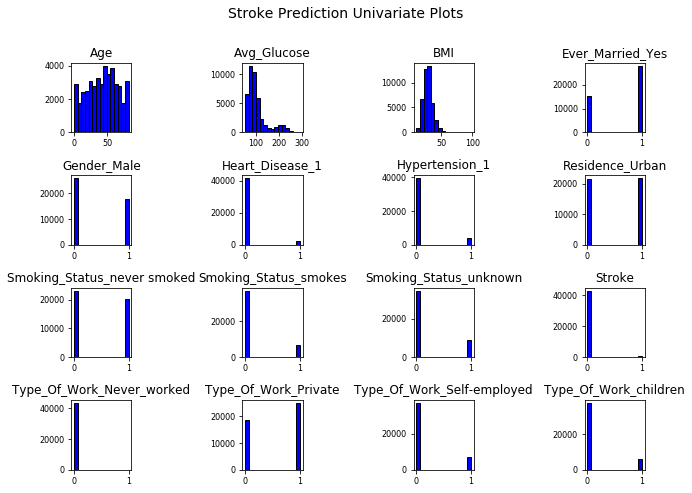

In [118]:
stroke_pred1.hist(bins=15, color='blue', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.6, 1.6))   
rt = plt.suptitle('Stroke Prediction Univariate Plots', x=0.8, y=1.7, fontsize=14)

In [101]:
basic_stat = round(stroke_pred1.describe(),2)
basic_stat

,Hypertension_1,Heart_Disease_1,Gender_Male,Ever_Married_Yes,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Residence_Urban,Smoking_Status_never smoked,Smoking_Status_smokes,Smoking_Status_unknown,Age,Avg_Glucose,BMI,Stroke
count,43383.00,43383.00,43383.00,43383.00,43383.00,43383.00,43383.00,43383.00,43383.0,43383.00,43383.00,43383.00,43383.00,43383.00,43383.00,43383.00
mean,0.09,0.05,0.41,0.64,0.00,0.57,0.16,0.14,0.5,0.47,0.15,0.21,42.29,104.49,28.61,0.02
std,0.29,0.21,0.49,0.48,0.06,0.49,0.36,0.35,0.5,0.50,0.36,0.41,22.52,43.12,7.64,0.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.08,55.00,10.10,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,24.08,77.54,23.40,0.00
50%,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.0,0.00,0.00,0.00,44.04,91.58,28.10,0.00
75%,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.0,1.00,0.00,0.00,60.06,112.08,32.60,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,82.14,291.05,97.60,1.00


## 2. Train, Test split

In [78]:
# stp = stroke prediction
stp_features = stroke_pred1[cols[:-1]]
stp_features_names=stp_features.columns
stp_class_labels = stroke_pred1['Stroke']

stp_train_X, stp_test_X, stp_train_y, stp_test_y = train_test_split(stp_features, 
             stp_class_labels, test_size=0.3, random_state=42)

print(Counter(stp_train_y), Counter(stp_test_y))
print('Features:', list(stp_features_names))

Counter({0: 29831, 1: 537}) Counter({0: 12769, 1: 246})
Features: ['Hypertension_1', 'Heart_Disease_1', 'Gender_Male', 'Ever_Married_Yes', 'Type_Of_Work_Never_worked', 'Type_Of_Work_Private', 'Type_Of_Work_Self-employed', 'Type_Of_Work_children', 'Residence_Urban', 'Smoking_Status_never smoked', 'Smoking_Status_smokes', 'Smoking_Status_unknown', 'Age', 'Avg_Glucose', 'BMI']


% of Strokes labels = 0.018
there is a clear need to rebalance the datasets


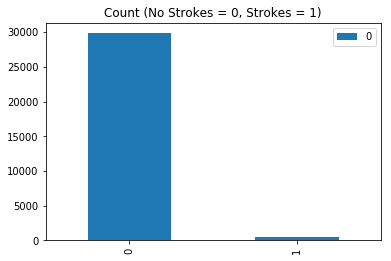

In [11]:
Counterdf=pd.DataFrame([Counter(stp_train_y)[0],Counter(stp_train_y)[1]])
Counterdf.plot(kind='bar', title='Count (No Strokes = 0, Strokes = 1)');
print('% of Strokes labels =', round(Counter(stp_train_y)[1]/Counter(stp_train_y)[0],3))
print('there is a clear need to rebalance the datasets')

In [12]:
stp_train_X.head()

,Hypertension_1,Heart_Disease_1,Gender_Male,Ever_Married_Yes,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Residence_Urban,Smoking_Status_never smoked,Smoking_Status_smokes,Smoking_Status_unknown,Age,Avg_Glucose,BMI
41014,0,0,0,0,0,0,0,1,0,1,0,0,0.683288,70.27,14.6
15171,0,0,0,1,0,1,0,0,0,0,0,1,53.106849,89.12,25.7
32054,0,0,0,0,0,1,0,0,1,1,0,0,19.035616,60.03,31.0
8282,0,0,0,1,0,1,0,0,1,0,0,1,57.005479,95.18,23.9
22572,0,0,0,1,0,1,0,0,0,0,0,1,38.043836,94.61,38.3


In [13]:
stp_train_X.dtypes

Hypertension_1                   uint8
Heart_Disease_1                  uint8
Gender_Male                      uint8
Ever_Married_Yes                 uint8
Type_Of_Work_Never_worked        uint8
Type_Of_Work_Private             uint8
Type_Of_Work_Self-employed       uint8
Type_Of_Work_children            uint8
Residence_Urban                  uint8
Smoking_Status_never smoked      uint8
Smoking_Status_smokes            uint8
Smoking_Status_unknown           uint8
Age                            float64
Avg_Glucose                    float64
BMI                            float64
dtype: object

## 3. Data standardization

### Scaling of the data (data standardization)

- We do this so that when we are running models (logistic regression, SVMs, perceptrons, neural networks etc.) 
the estimated weights will update similarly rather than at different rates during the build process.
- This will give us more accurate results with sklearn.
- **We do this only on numeric variables (Age, Avg_Glucose, BMI)** excluding our binary and categorical variables

In [15]:
num_cols=['Age', 'Avg_Glucose', 'BMI']

stp_ss = StandardScaler().fit(stp_train_X[num_cols])

# Scale the train set numeric variable
stp_train_X[num_cols] = stp_ss.transform(stp_train_X[num_cols])

# Scale the test set numeric variable
stp_test_X[num_cols] = stp_ss.transform(stp_test_X[num_cols])

warnings.filterwarnings("ignore")


### Normalization of the data: we will not do that

- We will then use the MinMaxScaler to normalize the X values between [0,1]
- This is a requirement to use CHi2 test for feature selection (X must be >0). 
- Issue, this could eliminate the outliers. 

In [20]:
#stp_mm = MinMaxScaler().fit(stp_train_X[num_cols])

# Scale the train set numeric variable
#stp_train_X[num_cols] = stp_mm.transform(stp_train_X[num_cols])
# Scale the test set numeric variable
#stp_test_X[num_cols] = stp_mm.transform(stp_test_X[num_cols])


## 4. Simple model testing

### 4.1 Naive model  (logistic regression) ignoring class imbalance

In [16]:
from sklearn.linear_model import LogisticRegression

stp_lr = LogisticRegression()
stp_lr.fit(stp_train_X, stp_train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
stp_lr_predictions = stp_lr.predict(stp_test_X)
meu.display_model_performance_metrics(true_labels=stp_test_y,
     predicted_labels=stp_lr_predictions, classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.9811
Precision: 0.9626
Recall: 0.9811
F1 Score: 0.9717

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.98      1.00      0.99     12769
          1       0.00      0.00      0.00       246

avg / total       0.96      0.98      0.97     13015


Prediction Confusion Matrix:
------------------------------
          Predicted:   
                   0  1
Actual: 0      12769  0
        1        246  0


**Conclusion**: 
- Due to the class imbalance, the model is biased and predicts everytime no stroke, which is not very useful. Next, we will address this.


### 4.2 Simple model with rebalanced classes 

- There are many ways to do an oversampling and undersampling of a data sets. 
- We will use some of the best strategies described here:
    - source: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets  
- We will install imblearn to perform an over-sampling using SMOTE and undersampling using TOMEK links
    - source https://imbalanced-learn.readthedocs.io/en/stable/about.html

**Over-sampling: SMOTE**
- SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
based on those that already exist. It works randomly picingk a point from the minority class 
and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point
and its neighbors.

**Under-sampling: TOMEK links**
- Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class 
of each pair increases the space between the two classes, facilitating the classification process.


In [18]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_train_smt, y_train_smt = smt.fit_sample(stp_train_X, stp_train_y)

#if time allows, plot_2d_space(X_train_smt, y_train_smt, 'SMOTE + Tomek links')


% of Strokes labels = 1.0
our data sets are now balanced


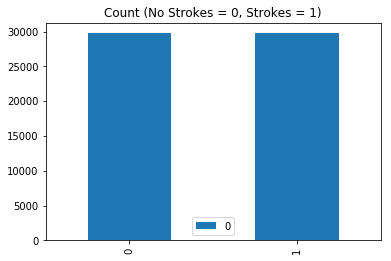

In [20]:
Counterdf=pd.DataFrame([Counter(y_train_smt)[0],Counter(y_train_smt)[1]])
Counterdf.plot(kind='bar', title='Count (No Strokes = 0, Strokes = 1)');
print('% of Strokes labels =', round(Counter(y_train_smt)[1]/Counter(y_train_smt)[0],3))
print('our data sets are now balanced')

In [21]:
from sklearn.linear_model import LogisticRegression

stp_lr = LogisticRegression()
stp_lr.fit(X_train_smt, y_train_smt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We rebalance the test data as well (this should gives better accuracy, we will check)

In [22]:
X_test_smt, y_test_smt = smt.fit_sample(stp_test_X, stp_test_y)

In [23]:
stp_lr_predictions = stp_lr.predict(X_test_smt)
meu.display_model_performance_metrics(true_labels=y_test_smt,
     predicted_labels=stp_lr_predictions, classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.7843
Precision: 0.7858
Recall: 0.7843
F1 Score: 0.784

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.81      0.75      0.78     12755
          1       0.76      0.82      0.79     12755

avg / total       0.79      0.78      0.78     25510


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0       9539   3216
        1       2287  10468


**Conclusion** 

- Performance (balanced train and test data): 78% accuracy, 79% precision,78% F1 score)
    - **We get the best accuracy performance by balancing both the train and test data.**
    - We care about accuracy since we want to predict as many stroke risks as possible
    - This becomes our benchmark for our model performance

### 4.3 Add new features using polynomial

- We will now use scikit-learn to add new interaction features to the model by using the polynomial fonction.
- The idea is to get a better binary classifier by looking at the correlation of combination of features with Strokes
- We will only create interaction between 2 features to avoid an explosion of features. 
Source: 
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html    

In [24]:
features_df=pd.DataFrame(data=X_train_smt,    # values
    index=X_train_smt[0:,0],    # 1st column as index
    columns=list(stp_features_names))  # 1st row as the column names

In [25]:
features_df.shape

(59528, 15)

In [27]:
stp_features_names

Index(['Hypertension_1', 'Heart_Disease_1', 'Gender_Male', 'Ever_Married_Yes',
       'Type_Of_Work_Never_worked', 'Type_Of_Work_Private',
       'Type_Of_Work_Self-employed', 'Type_Of_Work_children',
       'Residence_Urban', 'Smoking_Status_never smoked',
       'Smoking_Status_smokes', 'Smoking_Status_unknown', 'Age', 'Avg_Glucose',
       'BMI'],
      dtype='object')

In [28]:
int_cols=['Hypertension_1', 'Heart_Disease_1', 'Gender_Male', 'Ever_Married_Yes',
       'Type_Of_Work_Never_worked', 'Type_Of_Work_Private',
       'Type_Of_Work_Self-employed', 'Type_Of_Work_children',
       'Residence_Urban', 'Smoking_Status_never smoked',
       'Smoking_Status_smokes', 'Smoking_Status_unknown']
features_df[int_cols]=features_df[int_cols].astype(int)
features_df.head(2)

,Hypertension_1,Heart_Disease_1,Gender_Male,Ever_Married_Yes,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Residence_Urban,Smoking_Status_never smoked,Smoking_Status_smokes,Smoking_Status_unknown,Age,Avg_Glucose,BMI
0.0,0,0,0,0,0,0,0,1,0,1,0,0,-1.850470,-0.794488,-1.832740
0.0,0,0,0,1,0,1,0,0,0,0,0,1,0.481418,-0.355295,-0.384863


In [30]:
y_train_smt=y_train_smt.astype(int)
y_test_smt=y_test_smt.astype(int)

In [31]:
p=PolynomialFeatures(degree=2, interaction_only=True, include_bias=True).fit(features_df)

In [32]:
features_name_poly=p.get_feature_names(features_df.columns)


In [33]:
features_name_poly

['1',
 'Hypertension_1',
 'Heart_Disease_1',
 'Gender_Male',
 'Ever_Married_Yes',
 'Type_Of_Work_Never_worked',
 'Type_Of_Work_Private',
 'Type_Of_Work_Self-employed',
 'Type_Of_Work_children',
 'Residence_Urban',
 'Smoking_Status_never smoked',
 'Smoking_Status_smokes',
 'Smoking_Status_unknown',
 'Age',
 'Avg_Glucose',
 'BMI',
 'Hypertension_1 Heart_Disease_1',
 'Hypertension_1 Gender_Male',
 'Hypertension_1 Ever_Married_Yes',
 'Hypertension_1 Type_Of_Work_Never_worked',
 'Hypertension_1 Type_Of_Work_Private',
 'Hypertension_1 Type_Of_Work_Self-employed',
 'Hypertension_1 Type_Of_Work_children',
 'Hypertension_1 Residence_Urban',
 'Hypertension_1 Smoking_Status_never smoked',
 'Hypertension_1 Smoking_Status_smokes',
 'Hypertension_1 Smoking_Status_unknown',
 'Hypertension_1 Age',
 'Hypertension_1 Avg_Glucose',
 'Hypertension_1 BMI',
 'Heart_Disease_1 Gender_Male',
 'Heart_Disease_1 Ever_Married_Yes',
 'Heart_Disease_1 Type_Of_Work_Never_worked',
 'Heart_Disease_1 Type_Of_Work_Private

In [34]:
X_train_poly= p.fit_transform(X_train_smt)
X_train_poly.shape

(59528, 121)

In [35]:
features_poly_train_df = pd.DataFrame(X_train_poly, columns=features_name_poly)

In [36]:
features_poly_train_df.head(4)

,1,Hypertension_1,Heart_Disease_1,Gender_Male,Ever_Married_Yes,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Residence_Urban,...,Smoking_Status_smokes Smoking_Status_unknown,Smoking_Status_smokes Age,Smoking_Status_smokes Avg_Glucose,Smoking_Status_smokes BMI,Smoking_Status_unknown Age,Smoking_Status_unknown Avg_Glucose,Smoking_Status_unknown BMI,Age Avg_Glucose,Age BMI,Avg_Glucose BMI
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.000000,1.470177,3.391429,1.456090
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.0,-0.0,0.481418,-0.355295,-0.384863,-0.171045,-0.185280,0.136740
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,-0.0,-0.0,0.0,-0.000000,-0.000000,0.000000,1.068330,-0.316925,-0.316602
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,-0.0,-0.0,0.654836,-0.214100,-0.619654,-0.140200,-0.405771,0.132668


In [37]:
X_test_poly= p.fit_transform(X_test_smt)
X_test_poly.shape

(25510, 121)

In [38]:
features_poly_test_df = pd.DataFrame(X_test_poly, columns=features_name_poly)


In [40]:
features_poly_test_df.sum(axis=0)

1                                                     25510.000000
Hypertension_1                                         3681.464772
Heart_Disease_1                                        2568.655674
Gender_Male                                           11274.012769
Ever_Married_Yes                                      19955.635819
Type_Of_Work_Never_worked                                59.000000
Type_Of_Work_Private                                  14928.821818
Type_Of_Work_Self-employed                             5697.668784
Type_Of_Work_children                                  1892.000000
Residence_Urban                                       12533.994943
Smoking_Status_never smoked                           10852.915806
Smoking_Status_smokes                                  3911.381936
Smoking_Status_unknown                                 4998.039643
Age                                                   14674.913395
Avg_Glucose                                            8597.32

In [41]:
stp_lr = LogisticRegression()
stp_lr.fit(X_train_poly, y_train_smt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
stp_lr_predictions = stp_lr.predict(X_test_poly)
meu.display_model_performance_metrics(true_labels=y_test_smt,
     predicted_labels=stp_lr_predictions, classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.7752
Precision: 0.7757
Recall: 0.7752
F1 Score: 0.7751

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.79      0.75      0.77     12755
          1       0.76      0.80      0.78     12755

avg / total       0.78      0.78      0.78     25510


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0       9629   3126
        1       2608  10147


**Conclusion**

- Performance (balanced train and test data): 79% accuracy, 78% precision,78% F1 score)
- Performance (balanced train and test, with interaction): 78% accuracy, 78% precision,78% F1 score)       
 - No improvement in performance with interaction features.
 - We will now select the best features and see if we can improve the performance of the model further. 

### 4.4 Select Features using most common methods

- We will use 3 methods: wrapper, embedding, PCA and test model accuracy for each (logistic regression, as a benchmark). 
- Note: we won't use chi2 filter method as X attributes are negative.

#### 4.4.1 Wrapper Method 

- We rank and score features with the help of a Machine Learning based model estimator called RFE (Recursive Feature Elimination).
- We will prune out features with the least importance based on the use of an algorithm (logistic regression) until we reach our target number of features

In [43]:
from sklearn.feature_selection import RFE

#### The following selection of features may last several minutes

In [44]:
lr = LogisticRegression()
rfe=RFE(estimator=lr, n_features_to_select=15, step=1)
rfe.fit(X_train_poly, y_train_smt)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=15, step=1, verbose=0)

In [45]:
select_features_rfe = rfe.get_support()

In [76]:
selection_rfe=select_features_rfe.tolist()

In [47]:
feature_names_rfe = [x for x, y in zip(features_name_poly, selection_rfe) if y == True]
feature_names_rfe

['Type_Of_Work_Never_worked',
 'Type_Of_Work_children',
 'Age',
 'Heart_Disease_1 Smoking_Status_smokes',
 'Gender_Male Type_Of_Work_children',
 'Ever_Married_Yes Type_Of_Work_children',
 'Type_Of_Work_Private Type_Of_Work_Self-employed',
 'Type_Of_Work_Private Type_Of_Work_children',
 'Type_Of_Work_Private Smoking_Status_smokes',
 'Type_Of_Work_children Age',
 'Type_Of_Work_children Avg_Glucose',
 'Type_Of_Work_children BMI',
 'Smoking_Status_never smoked Smoking_Status_smokes',
 'Smoking_Status_never smoked Smoking_Status_unknown',
 'Smoking_Status_smokes Smoking_Status_unknown']

- Compare set of features selected via Kbest and rfe

In [51]:
#set(feature_names_kbest) & set(feature_names_rfe)

- Create X_train_rfe and X_test_rfe

In [54]:
X_train_rfe=features_poly_train_df[feature_names_rfe].values

In [55]:
X_test_rfe=features_poly_test_df[feature_names_rfe].values

In [56]:
stp_lr = LogisticRegression()
stp_lr.fit(X_train_rfe, y_train_smt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
stp_lr_predictions = stp_lr.predict(X_test_rfe)
meu.display_model_performance_metrics(true_labels=y_test_smt,
     predicted_labels=stp_lr_predictions, classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.7816
Precision: 0.7844
Recall: 0.7816
F1 Score: 0.7811

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.81      0.73      0.77     12755
          1       0.76      0.83      0.79     12755

avg / total       0.78      0.78      0.78     25510


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0       9338   3417
        1       2154  10601


**Conclusion**

- Performance (balanced train and test data): 78% accuracy, 79% precision,78% F1 score)
- Performance (balanced train and test, with interaction): 78% accuracy, 78% precision,78% F1 score)  
- Performance (... with selection using wrapper method):   78% accuracy, 78% precision, 78% F1 score)

- Same as interaction with 15 attributes instead of 121, but not better than original model.

#### 4.4.2 Model Based Selection

- We can use Random forest (an ensemble model) as an embedded feature selection method, where each decision tree model in the ensemble is built by taking a training sample of data from the entire dataset. 
- This sample is a bootstrap sample (sample taken with replacement). 
- Splits at any node are taken by choosing the best split from a random subset of the features
rather than taking all the features into account. This tend to reduce the variance at a slight bias cost.

In [58]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_poly, y_train_smt)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
importance_scores = rfc.feature_importances_
feature_importances = [(feature, score) for feature, score in zip(features_name_poly, importance_scores)]
sort=sorted(feature_importances, key=lambda x: -x[1])[:30]
sort

[('Age', 0.09383815587544964),
 ('Ever_Married_Yes Age', 0.09131117629967736),
 ('Type_Of_Work_Private Age', 0.053308525666833105),
 ('Residence_Urban Age', 0.04832387748519209),
 ('Gender_Male Age', 0.03111154191028611),
 ('Ever_Married_Yes', 0.027184173613898945),
 ('Ever_Married_Yes Avg_Glucose', 0.026972202180553954),
 ('Hypertension_1 Age', 0.023193795563605058),
 ('BMI', 0.022758251128641924),
 ('Avg_Glucose', 0.022707894134797894),
 ('Ever_Married_Yes BMI', 0.021287177949588502),
 ('Type_Of_Work_Self-employed Age', 0.020250107276859955),
 ('Age Avg_Glucose', 0.019826497796251084),
 ('Avg_Glucose BMI', 0.018777860037233165),
 ('Age BMI', 0.01757062515650812),
 ('Smoking_Status_never smoked Age', 0.017539741155862813),
 ('Type_Of_Work_Private BMI', 0.017295310463692738),
 ('Residence_Urban Avg_Glucose', 0.016250668441061548),
 ('Type_Of_Work_Private Avg_Glucose', 0.015957905498177972),
 ('Residence_Urban BMI', 0.015063739093139272),
 ('Type_Of_Work_children BMI', 0.013655757631906

In [60]:
feature_names_rfc=[]
for i in range(len(sort)):
    feature_names_rfc.extend([sort[i][0]])
feature_names_rfc

['Age',
 'Ever_Married_Yes Age',
 'Type_Of_Work_Private Age',
 'Residence_Urban Age',
 'Gender_Male Age',
 'Ever_Married_Yes',
 'Ever_Married_Yes Avg_Glucose',
 'Hypertension_1 Age',
 'BMI',
 'Avg_Glucose',
 'Ever_Married_Yes BMI',
 'Type_Of_Work_Self-employed Age',
 'Age Avg_Glucose',
 'Avg_Glucose BMI',
 'Age BMI',
 'Smoking_Status_never smoked Age',
 'Type_Of_Work_Private BMI',
 'Residence_Urban Avg_Glucose',
 'Type_Of_Work_Private Avg_Glucose',
 'Residence_Urban BMI',
 'Type_Of_Work_children BMI',
 'Heart_Disease_1 Ever_Married_Yes',
 'Gender_Male Avg_Glucose',
 'Heart_Disease_1 Age',
 'Smoking_Status_never smoked Avg_Glucose',
 'Residence_Urban',
 'Type_Of_Work_Self-employed BMI',
 'Hypertension_1 Ever_Married_Yes',
 'Gender_Male',
 'Type_Of_Work_Private Residence_Urban']

In [ ]:
#(feature_names_kbest) & set(feature_names_rfc)

In [61]:
set(feature_names_rfc) & set(feature_names_rfe)

{'Age', 'Type_Of_Work_children BMI'}

In [62]:
X_train_rfc=features_poly_train_df[feature_names_rfc].values

In [63]:
X_test_rfc=features_poly_test_df[feature_names_rfc].values

In [64]:
stp_lr = LogisticRegression()
stp_lr.fit(X_train_rfc, y_train_smt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
stp_lr_predictions = stp_lr.predict(X_test_rfc)
meu.display_model_performance_metrics(true_labels=y_test_smt,
predicted_labels=stp_lr_predictions, classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.7797
Precision: 0.781
Recall: 0.7797
F1 Score: 0.7795

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.80      0.75      0.77     12755
          1       0.76      0.81      0.79     12755

avg / total       0.78      0.78      0.78     25510


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0       9524   3231
        1       2388  10367


**Conclusion**

- Performance (balanced train and test data): 79% accuracy, 78% precision,78% F1 score)
- Performance (balanced train and test, with interaction): 78% accuracy, 78% precision,78% F1 score)  
- Performance (... with selection using wrapper method):   78% accuracy, 78% precision, 78% F1 score)
- Performance (...with selection using random forest):     78% accuracy, 78% precision, 78% F1 score

### 4.43 Dimensionality reduction using PCA (feature extraction)

- PCA: statistical method that uses the process of linear, orthogonal transformation to transform a higher-dimensional set of features that could be possibly
correlated into a lower-dimensional set of linearly uncorrelated features.
- feature matrix as (F(n x D)) = USVT. The Principal Components are the vectors in VT

In [67]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(X_train_poly)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [68]:
pca.explained_variance_ratio_

array([0.26421059, 0.11831951, 0.08094241, 0.05185624, 0.04334514,
       0.04206976, 0.03154917, 0.02876567, 0.02633163, 0.02518236,
       0.02241225, 0.02040666, 0.01801412, 0.01645898, 0.01541512,
       0.01312597, 0.01127176, 0.01019904, 0.009639  , 0.00888882,
       0.00851573, 0.00776265, 0.00744181, 0.00722526, 0.00701025,
       0.00672772, 0.00612581, 0.00566663, 0.00557122, 0.00504344])

Comment: the first 30 extracted features explain 90% of the variance. (top 5 explains 50%).

In [69]:
X_train_pca = pca.transform(X_train_poly)
np.round(X_train_pca, 2)

array([[-1.14,  4.97, -0.76, ..., -0.07, -0.59,  0.33],
       [-1.37, -0.  , -0.37, ..., -0.01, -0.05,  0.09],
       [-2.04,  2.07,  0.26, ..., -0.14, -0.77, -0.4 ],
       ...,
       [-0.92, -0.72,  2.05, ..., -0.21, -0.15, -0.02],
       [-1.99, -0.38,  0.21, ..., -0.12,  0.1 , -0.01],
       [-2.  , -1.99, -0.92, ...,  0.08, -0.25, -0.15]])

In [70]:
pca = PCA(n_components=30)
pca.fit(X_train_poly)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [71]:
X_test_pca = pca.transform(X_test_poly)

In [72]:
stp_lr = LogisticRegression()
stp_lr.fit(X_train_pca, y_train_smt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
stp_lr_predictions = stp_lr.predict(X_test_pca)
meu.display_model_performance_metrics(true_labels=y_test_smt,
predicted_labels=stp_lr_predictions, classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.7759
Precision: 0.7762
Recall: 0.7759
F1 Score: 0.7758

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.79      0.76      0.77     12755
          1       0.77      0.79      0.78     12755

avg / total       0.78      0.78      0.78     25510


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0       9668   3087
        1       2631  10124



**Conclusion**
- Performance (balanced train and test data): 79% accuracy, 79% precision,78% F1 score)
- Performance (balanced train and test, with interaction): 78% accuracy, 78% precision,78% F1 score)  
- Performance (... with selection using wrapper method):   78% accuracy, 78% precision, 78% F1 score)
- Performance (...with selection using random forest):     78% accuracy, 78% precision, 78% F1 score   
- Performance (...with extraction using PCA):              78% accuracy, 78% precision, 78% F1 score
    - Note: PCA offers similar scores as Random Forest, CHi2, but more difficult to explain the features). 

- Next: 
  - We will now test different models based on the list of features selected using wrapper method
  - If time allows, we will also check if we can improve the features by binning some of them.

** Saving the variables for use in next Notebook**

In [96]:
# We use pickle to save our variables

## Save the train /test variables with rebalanced classes
with open('train_smt.pickle', 'wb') as f:
    pickle.dump([X_train_smt, y_train_smt], f)
     
with open('test_smt.pickle', 'wb') as f:
    pickle.dump([X_test_smt, y_test_smt], f)

## Save features names
with open('stp_features_names.pickle', 'wb') as f:
    pickle.dump([list(stp_features_names)], f)
    
    

## Save the test variables 

with open('test.pickle', 'wb') as f:
    pickle.dump([stp_test_X, stp_test_y], f)
    
## Save Rfe selected features names
#with open('feature_names_rfe.pickle', 'wb') as f:
 #   pickle.dump([feature_names_rfe], f)
    


## 5 Binning

In [ ]:
3. Analysis of the model without feature engineering

In [ ]:

Testing multiple models 

https://www.kaggle.com/tflare/testing-multiple-models-with-scikit-learn-0-79425

Grid search
https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html
    

In [ ]:
MODEL APPROACH

1 TRY THE MODEL 
0. Hot encode the data 
1. run a simple model (without downsampling) Log Reg. Gives the baseline
2. down sample . Re run de model
3. Normalize / scale Re run the model
4. Bin (age, ...) run the model 
(+/-) of binning.
https://stats.stackexchange.com/questions/68834/what-is-the-benefit-of-breaking-up-a-continuous-predictor-variable

or 
3.  Bin
4. normalize run the model 

Show the result with F1 score with Cross validation (if poss)

Once you have the right set up. 

2. MULTIPLE MODEL COMPARISON
Perform the model wtih multiple model comparison (grid search...)

Feature selection and selecting multiple models 
https://scikit-learn.org/stable/modules/feature_selection.html

Testing multiple models 

https://www.kaggle.com/tflare/testing-multiple-models-with-scikit-learn-0-79425

Grid search
https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html
    


In [113]:
a = feature_names_rfe
for c in ['Hypertension_0 Hypertension_1','Heart_Disease_0 Heart_Disease_1','Gender_Female Gender_Male',
          'Ever_Married_No Ever_Married_Yes','Residence_Rural Residence_Urban',
          'Smoking_Status_never smoked Smoking_Status_smokes',
          'Smoking_Status_formerly smoked Smoking_Status_never smoked']:
    if c in a:
        a.remove(c)
a

['Age',
 'Type_Of_Work_Govt_job Type_Of_Work_Private',
 'Type_Of_Work_Govt_job Type_Of_Work_Self-employed',
 'Type_Of_Work_Private Type_Of_Work_Self-employed',
 'Smoking_Status_formerly smoked Smoking_Status_smokes',
 'Smoking_Status_formerly smoked Smoking_Status_unknown',
 'Smoking_Status_never smoked Smoking_Status_unknown',
 'Smoking_Status_smokes Smoking_Status_unknown']

In [ ]:
4. Analysis of the model with feature engineering

In [ ]:
Feature engineering: adding interaction terms 

https://chrisalbon.com/machine_learning/linear_regression/adding_interaction_terms/
    

In [ ]:
Model Explainability: 
    
Use LIME or SHP to explain variables which have the most impact.